In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.tri as tri
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import scipy.io as io

import torch

from sbi.analysis import pairplot

from openTSNE import TSNE

# load and read nwb files
from pynwb import NWBHDF5IO

from ephys_utils import get_time_voltage_current_currindex0, syn_current

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
def adjust_spines(ax, spines, spine_pos=5, color='k', linewidth=None, smart_bounds=True):
    """Convenience function to adjust plot axis spines."""

    # If no spines are given, make everything invisible
    if spines is None:
        ax.axis('off')
        return

    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', spine_pos))  # outward by x points
            #spine.set_smart_bounds(smart_bounds)
            spine.set_color(color)
            if linewidth is not None:
                spine.set_linewidth = linewidth
        else:
            spine.set_visible(False)  # make spine invisible
            # spine.set_color('none')  # this will interfere w constrained plot layout

    # Turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # No visible yaxis ticks and tick labels
        # ax.yaxis.set_visible(False)  # hides whole axis, incl. ax label
        # ax.yaxis.set_ticks([])  # for shared axes, this would delete ticks for all
        plt.setp(ax.get_yticklabels(), visible=False)  # hides ticklabels but not ticks
        plt.setp(ax.yaxis.get_ticklines(), color='none')  # changes tick color to none
        # ax.tick_params(axis='y', colors='none')  # (same as above) changes tick color to none

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # No visible xaxis ticks and tick labels
        # ax.xaxis.set_visible(False)  # hides whole axis, incl. ax label
        # ax.xaxis.set_ticks([])  # for shared axes, this would  delete ticks for all
        plt.setp(ax.get_xticklabels(), visible=False)  # hides ticklabels but not ticks
        plt.setp(ax.xaxis.get_ticklines(), color='none')  # changes tick color to none

### Load observed data

In [5]:
M1_25degree = pickle.load(open('pickles/M1_features.pickle', 'rb'))
ephys_features = np.array(M1_25degree['X_o'].columns)[:-4]
Xo = M1_25degree['X_o'].copy()
feature_list=range(23)

In [6]:
prop = pd.read_csv('../data/m1_patchseq_meta_data.csv', sep = '\t')
prop = prop.rename(columns = {'Targeted layer': 'Layer'})
prop = prop[['Cell', 'Layer', 'Cre', 'RNA type']]
prop = prop.set_index('Cell')
prop=prop.reindex(Xo.index)
no_low_qual=np.array(list(map(str,prop['RNA type'].values)))!='nan'
prop=prop.loc[no_low_qual,:]
Xo = Xo.loc[no_low_qual,:]
celltypes=prop['RNA type']

In [7]:
annotations = pd.read_csv('../data/cluster.annotation.csv',index_col=0)
cellTypeColors={}
for celltype in np.unique(annotations['cluster_label'].values):
    cellTypeColors.update({celltype:annotations.iloc[np.where(annotations['cluster_label']==celltype)[0][0],:]\
                          ['cluster_color']})
colors=np.array([cellTypeColors[celltype] for celltype in celltypes])

In [8]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', r'$r_{SS}$'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3]

In [9]:
# Vip
celltype_Vip = (celltypes=='Vip C1ql1') | (celltypes=='Vip Chat_1') | (celltypes=='Vip Gpc3') | \
            (celltypes=='Vip Htr1f') | (celltypes=='Vip Mybpc1_1') | (celltypes=='Vip Mybpc1_2') | \
            (celltypes=='Vip Mybpc1_3') | (celltypes=='Vip Serpinf1_1') | (celltypes=='Vip Serpinf1_2') | \
            (celltypes=='Vip Serpinf1_3') | (celltypes=='Vip Sncg')

# Sst
celltype_Sst = (celltypes=='Sst C1ql3_1') | (celltypes=='Sst C1ql3_2') | (celltypes=='Sst Calb2') | \
       (celltypes=='Sst Chodl') | (celltypes=='Sst Crhr2_1') | (celltypes=='Sst Crhr2_2') | \
       (celltypes=='Sst Etv1') | (celltypes=='Sst Hpse') | (celltypes=='Sst Htr1a') | \
       (celltypes=='Sst Myh8_1') | (celltypes=='Sst Myh8_2') | (celltypes=='Sst Myh8_3') | \
       (celltypes=='Sst Penk') | (celltypes=='Sst Pvalb Calb2') | (celltypes=='Sst Pvalb Etv1') | \
       (celltypes=='Sst Tac2') | (celltypes=='Sst Th_1') | (celltypes=='Sst Th_3')

# Lamp5
celltype_Lamp5 = (celltypes=='Lamp5 Egln3_1') | (celltypes=='Lamp5 Egln3_2') | (celltypes=='Lamp5 Lhx6') | \
            (celltypes=='Lamp5 Pax6') | (celltypes=='Lamp5 Pdlim5_1') | (celltypes=='Lamp5 Pdlim5_2') | \
            (celltypes=='Lamp5 Slc35d3')

# Pvalb
celltype_Pvalb = (celltypes=='Pvalb Calb1_1') | (celltypes=='Pvalb Calb1_2') | (celltypes=='Pvalb Egfem1') | \
       (celltypes=='Pvalb Gabrg1') | (celltypes=='Pvalb Gpr149') | (celltypes=='Pvalb Il1rapl2') | \
       (celltypes=='Pvalb Kank4') | (celltypes=='Pvalb Reln') | (celltypes=='Pvalb Vipr2_2')

# Pyramidal
celltype_Pyr = (celltypes=='L2/3 IT_3') | (celltypes=='L4/5 IT_1') | (celltypes=='L4/5 IT_2') | \
           (celltypes=='L5 ET_1') | (celltypes=='L5 ET_2') | (celltypes=='L5 ET_3') | \
           (celltypes=='L5 ET_4') | (celltypes=='L5 IT_1') | (celltypes=='L5 IT_2') | \
           (celltypes=='L5 IT_3') | (celltypes=='L5 IT_4') | (celltypes=='L5/6 NP CT') | \
           (celltypes=='L5/6 NP_1') | (celltypes=='L5/6 NP_2') | (celltypes=='L6 CT Cpa6') | \
           (celltypes=='L6 CT Grp') | (celltypes=='L6 CT Pou3f2') | (celltypes=='L6 IT_1') | \
           (celltypes=='L6 IT_2') | (celltypes=='L6b Col6a1') | (celltypes=='L6b Kcnip1') | \
           (celltypes=='L6b Ror1') | (celltypes=='L6b Shisa6_1') | (celltypes=='L6b Shisa6_2')
# Sncg
celltype_Sncg = (celltypes=='Sncg Calb1_2') | (celltypes=='Sncg Npy2r') | (celltypes=='Sncg Calb1_1') | \
                (celltypes=='Sncg Col14a1')

Some numbers to report in the manuscript:

In [10]:
sum(celltype_Pyr)

278

In [11]:
sum(celltype_Sst)

240

In [12]:
sum(celltype_Vip)

54

In [13]:
sum(celltype_Sncg)

11

In [14]:
sum(celltype_Pvalb)

289

In [15]:
sum(celltype_Vip) + sum(celltype_Sst) + sum(celltype_Lamp5) + sum(celltype_Pvalb) + sum(celltype_Sncg)

677

### Figure 1a

Illustrate model mismatch

In [16]:
dir_locs=[]
for cell_name in Xo.index:
    dir_locs.append(np.array(M1_25degree['M1_names'])[no_low_qual][np.where(Xo.index==cell_name)[0][0]])

Pick example cell

In [17]:
cell_name = '20180529_sample_3'

In [18]:
#Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree['M1_names'])[no_low_qual][np.where(Xo.index==cell_name)[0][0]]
data

'../data/raw_data/000008/sub-mouse-PAIFP/sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb'

In [19]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, 'r', load_namespaces=True).read()

In [20]:
xo=Xo.loc[cell_name,:].iloc[:-4].values
feature_list=range(23)

In [21]:
time_obs, voltage_obs, current_obs, curr_index_0_obs = get_time_voltage_current_currindex0(data)
liquid_junction_potential=15.4
voltage_obs-=liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(area=Xo.loc[cell_name, '1-comp area'], curr_level=3e-4)
curr_index = np.where(current_obs==300)[0][0]
observation = {'data': voltage_obs[:20000, curr_index], 'time': time_obs[:20000]*1e3, 'dt':4*1e-5*1e3, 'I': I}

In [22]:
lw=2

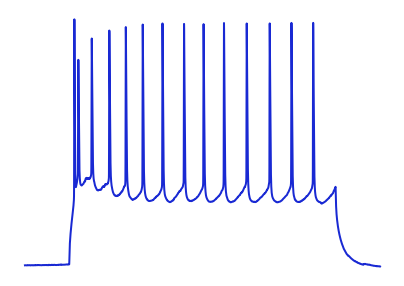

In [23]:
fig, ax_obs = plt.subplots(1,1, figsize=(7,5))
# Experimental observation
ax_obs.plot(observation['time'], observation['data'], c='#1929d3ff', lw=lw)
sns.despine(left=True, bottom=True, ax=ax_obs)
ax_obs.set_xticks([])
ax_obs.set_yticks([])
plt.savefig('../figures/preliminary/observation_example.png', bbox_inches = 'tight', pad_inches = 0, dpi=500)

In [24]:
# load prior simulations
theta=np.load('./save_sims/M1_chunks/full_batch.npz')['theta']
stats=np.load('./save_sims/M1_chunks/full_batch.npz')['stats']
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1))) # delete non-spiking simulations
stats=stats[keeping,:]
theta=theta[keeping,:]

tcmalloc: large alloc 1380007936 bytes == 0x3f124000 @ 


In [17]:
# # load prior simulations from model without rSS parameter (for suppl figure)
# theta_without_rSS=np.load('./without_rSS/save_sims/M1_chunks/full_batch.npz')['theta']
# stats_without_rSS=np.load('./without_rSS/save_sims/M1_chunks/full_batch.npz')['stats']
# keeping=(~np.isnan(np.mean(stats_without_rSS, axis=1)))&(~np.isinf(np.mean(stats_without_rSS, axis=1))) # delete non-spiking simulations
# stats_without_rSS=stats_without_rSS[keeping,:]
# theta_without_rSS=theta_without_rSS[keeping,:]

tcmalloc: large alloc 1380007936 bytes == 0xc65c4000 @ 


In [25]:
# find 1000 prior simulations closest to the experimental observation in terms of Z-scored ephys distance
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances=np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(xo[feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]

tcmalloc: large alloc 1316626432 bytes == 0xbbfa2000 @ 


In [26]:
# # same but for model without rSS parameter
# s_mean=stats_without_rSS[:,feature_list].mean(axis=0)
# s_std=stats_without_rSS[:,feature_list].std(axis=0)
# E_distances_without_rSS=np.sort(
#     np.sqrt(
#         np.sum(
#             (
#                 (stats_without_rSS[:,feature_list]-s_mean)/s_std
#                 -(xo[feature_list]-s_mean)/s_std
#             )**2,axis=1
#         )
#     )
# )[0:1000]

Next block takes a while. If performed once, you don't need to run it again and can just go to 2nd next block.

In [38]:
# now do it for all experimental observations
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_observations=[]
for i in range(Xo.shape[0]):
    if i%10==0:
        print(i,' ', end='')
    E_distances_one=np.sort(
        np.sqrt(
            np.sum(
                (
                    (stats[:,feature_list]-s_mean)/s_std
                    -(Xo.values[i,feature_list]-s_mean)/s_std
                )**2,axis=1
            )
        )
    )[0:1000]
    E_distances_observations.append(E_distances_one)
E_distances_observations=np.array(E_distances_observations)
np.savez('./save_sims/E_distances_observations.npz',
     distances=E_distances_observations
        )

0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520  530  540  550  560  570  580  590  600  610  620  630  640  650  660  670  680  690  700  710  720  730  740  750  760  770  780  790  800  810  820  830  840  850  860  870  880  890  900  910  920  930  940  950  

In [39]:
# # same but for model without rSS parameter
# s_mean=stats_without_rSS[:,feature_list].mean(axis=0)
# s_std=stats_without_rSS[:,feature_list].std(axis=0)
# E_distances_observations=[]
# for i in range(Xo.shape[0]):
#     if i%10==0:
#         print(i,' ', end='')
#     E_distances_one=np.sort(
#         np.sqrt(
#             np.sum(
#                 (
#                     (stats_without_rSS[:,feature_list]-s_mean)/s_std
#                     -(Xo.values[i,feature_list]-s_mean)/s_std
#                 )**2,axis=1
#             )
#         )
#     )[0:1000]
#     E_distances_observations.append(E_distances_one)
# E_distances_observations=np.array(E_distances_observations)
# np.savez('without_rSS/save_sims/E_distances_observations.npz',
#      distances=E_distances_observations
#         )

Next block takes a while. If performed once, you don't need to run it again and can just go to the next block.

In [40]:
# pick 1000 random prior simulations and perform for each of them an analogous analysis
selected_random_sims=np.random.randint(0,stats.shape[0],1000)
stats_picked=stats[selected_random_sims,:]
E_distances_prior=[]
for i in range(1000):
    if i%10==0:
        print(i,' ', end='')
    E_distances_prior_one=np.sort(
        np.sqrt(
            np.sum(
                (
                    (stats[:,feature_list]-s_mean)/s_std
                    -(stats_picked[i,feature_list]-s_mean)/s_std
                )**2,axis=1
            )
        )
    )[0:1000]
    E_distances_prior.append(E_distances_prior_one)
E_distances_prior=np.array(E_distances_prior)
np.savez('./save_sims/E_distances_prior.npz',
     distances=E_distances_prior,
     indices=selected_random_sims
    )

0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520  530  540  550  560  570  580  590  600  610  620  630  640  650  660  670  680  690  700  710  720  730  740  750  760  770  780  790  800  810  820  830  840  850  860  870  880  890  900  910  920  930  940  950  960  970  980  990  

In [27]:
E_distances_prior=np.load('./save_sims/E_distances_prior.npz')['distances']
E_distances_prior_indices=np.load('./save_sims/E_distances_prior.npz')['indices']
E_distances_observations=np.load('./save_sims/E_distances_observations.npz')['distances']
#E_distances_observations_without_rSS=np.load('without_rSS/save_sims/E_distances_observations.npz')['distances']

In [28]:
from simulator import EphysModel
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=40,
                   noise_factor=10,
                   use_pathos=True,
                   chunk_size=280,
                   save_chunks=True)

In [29]:
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_indexes=np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(xo[feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]
x_prior = M1_model._run_HH_model(theta[E_distances_indexes[[1,100,500]],:])

In [31]:
# from without_rSS.simulator import EphysModel
# M1_model=EphysModel(name='M1',
#                    T=25.0,
#                    E_Na=69.0,
#                    E_K=-98.4,
#                    E_Ca=127.2,
#                    start=100,
#                    end=700,
#                    dt=0.04,
#                    n_processes=40,
#                    noise_factor=10,
#                    use_pathos=True,
#                    chunk_size=280,
#                    save_chunks=True)

In [32]:
# s_mean=stats_without_rSS[:,feature_list].mean(axis=0)
# s_std=stats_without_rSS[:,feature_list].std(axis=0)
# E_distances_indexes_without_rSS=np.argsort(
#     np.sqrt(
#         np.sum(
#             (
#                 (stats_without_rSS[:,feature_list]-s_mean)/s_std
#                 -(xo[feature_list]-s_mean)/s_std
#             )**2,axis=1
#         )
#     )
# )[0:1000]

# x_prior_without_rSS = M1_model._run_HH_model(theta_without_rSS[E_distances_indexes_without_rSS[[1,100,500]],:])

In [33]:
# from simulator import EphysModel
# M1_model=EphysModel(name='M1',
#                    T=25.0,
#                    E_Na=69.0,
#                    E_K=-98.4,
#                    E_Ca=127.2,
#                    start=100,
#                    end=700,
#                    dt=0.04,
#                    n_processes=40,
#                    noise_factor=10,
#                    use_pathos=True,
#                    chunk_size=280,
#                    save_chunks=True)

In [30]:
sim_ind_ex=E_distances_prior_indices[np.argsort(E_distances_prior[:,-1])[round(E_distances_prior.shape[0]//2.2)]]

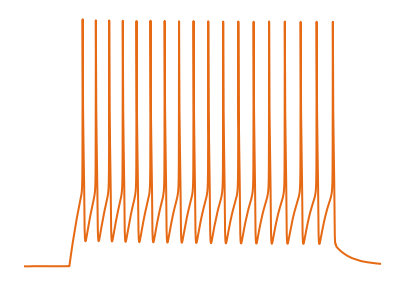

In [31]:
fig, ax_sim = plt.subplots(1,1, figsize=(7,5))
# Prior simulation
x_prior_example=M1_model._run_HH_model(theta[sim_ind_ex,:])
ax_sim.plot(x_prior_example['time'], x_prior_example['data'][0,0,:], c='#e66913ff', lw=lw)
sns.despine(left=True, bottom=True, ax=ax_sim)
ax_sim.set_xticks([])
ax_sim.set_yticks([])
plt.savefig('../figures/preliminary/simulation_example.png', bbox_inches = 'tight', pad_inches = 0, dpi=500)

In [32]:
# find 1000 prior simulations closest to a simulation in terms of Z-scored ephys distance
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_ex=np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(stats[sim_ind_ex,feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]

In [33]:
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_ex_indexes=np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(stats[sim_ind_ex,feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]
x_sim_prior = M1_model._run_HH_model(theta[E_distances_ex_indexes[[1,100,500]],:])

In [34]:
x_sim_ex = M1_model._run_HH_model(theta[sim_ind_ex,:])

In [35]:
fancy_colors = np.array(
    [
        [86, 100, 26], [192, 175, 251], [230, 161, 118],
        [0, 103, 138], [152, 68, 100], [94, 204, 171], 
        [205, 205, 205]
    ]
)/255

In [231]:
def create_figure_1d(fig):
    
    if fig is None:
        fig = plt.figure(figsize=(14, 8))
    else: fig = fig
    
    width=.14 # for membrane voltage traces
    height=.45 # for membrane voltage traces
    ax_mm_banana=plt.axes([0,0.15,.36,.8])
    axes_ex_1=np.array([plt.axes([x,.50,width,height]) for x in [.41,.56,.71,.86]])
    axes_ex_2=np.array([plt.axes([x,0.1,width,height]) for x in [.41,.56,.71,.86]])
    
    return ax_mm_banana, axes_ex_1, axes_ex_2

In [41]:
# def create_suppl_figure_1(fig):
#     # Suppl. Fig. 1: illustrate model mismatch including a model for which we don't introduce rSS
    
#     if fig is None:
#         fig = plt.figure(figsize=(14, 12))
#     else: fig = fig
    
#     width=.14 # for membrane voltage traces
#     height=.22 # for membrane voltage traces
#     ax_mm_banana=plt.axes([0,0.15,.36,.8])
#     axes_ex_1=np.array([plt.axes([x,.7,width,height]) for x in [.41,.56,.71,.86]])
#     axes_ex_2=np.array([plt.axes([x,0.4,width,height]) for x in [.41,.56,.71,.86]])
#     axes_ex_3=np.array([plt.axes([x,0.1,width,height]) for x in [.41,.56,.71,.86]])
    
#     return ax_mm_banana, axes_ex_1, axes_ex_2, axes_ex_3

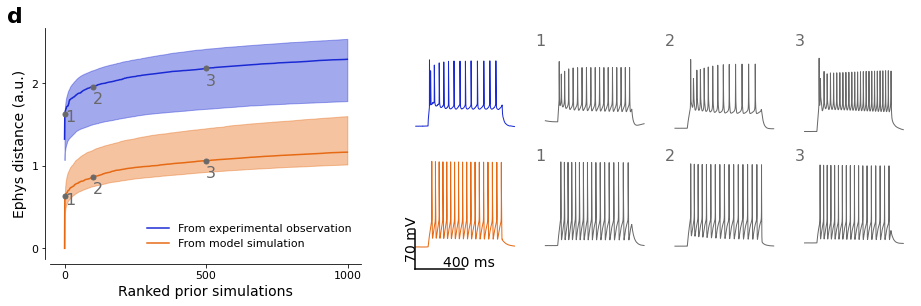

In [232]:
fig = plt.figure(figsize=(12, 4))
ax_mm_banana, axes_ex_1, axes_ex_2 = create_figure_1d(fig)

lw=1


# Model mismatch, banana
ax_mm_banana.plot(range(1000),E_distances, c='#1929d3ff', label='From experimental observation')
ax_mm_banana.plot(E_distances_ex, c='#e66913ff', label='From model simulation')
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_prior, 30, axis=0),
    np.percentile(E_distances_prior, 70, axis=0),
    color='#e66913ff',
    alpha=0.4
)
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_observations, 30, axis=0),
    np.percentile(E_distances_observations, 70, axis=0),
    color='#1929d3ff',
    alpha=0.4
)

ax_mm_banana.plot([1], [E_distances[1]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([100], [E_distances[100]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([500], [E_distances[500]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([1], [E_distances_ex[1]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([100], [E_distances_ex[100]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([500], [E_distances_ex[500]],
                          color='dimgray', marker='.', markersize=10)

ax_mm_banana.annotate('1',(1, E_distances[1]-.1), color='dimgray', fontsize=16)
ax_mm_banana.annotate('2',(100, E_distances[100]-.2), color='dimgray', fontsize=16)
ax_mm_banana.annotate('3',(500, E_distances[500]-.2), color='dimgray', fontsize=16)
ax_mm_banana.annotate('1',(1, E_distances_ex[1]-.1), color='dimgray', fontsize=16)
ax_mm_banana.annotate('2',(100, E_distances_ex[100]-.2), color='dimgray', fontsize=16)
ax_mm_banana.annotate('3',(500, E_distances_ex[500]-.2), color='dimgray', fontsize=16)
ax_mm_banana.set_xlabel("Ranked prior simulations", fontsize=14)
ax_mm_banana.set_ylabel("Ephys distance (a.u.)", fontsize=14)

ax_mm_banana.set_xticks([0,500,1000])
ax_mm_banana.set_yticks([0,1,2])
ax_mm_banana.tick_params(axis='both', which='major', labelsize=11)

ax_mm_banana.legend(loc='lower right', fontsize=11, frameon=False)

adjust_spines(ax_mm_banana, spines=['bottom', 'left'])

# Experimental observation and prior simulations close to it
axes_ex_1[0].plot(observation['time'], observation['data'], c='#1929d3ff', lw=lw)
axes_ex_1[0].set_ylim([axes_ex_1[0].get_ylim()[0]-50, axes_ex_1[0].get_ylim()[1]+50])
axes_ex_1[0].set_xlim([axes_ex_1[0].get_xlim()[0]-50, axes_ex_1[0].get_xlim()[1]+50])
#axes_ex_1[0].set_title('Experimental observation', fontsize=16)
axes_ex_1[0].set_xticks([])
axes_ex_1[0].set_yticks([])
sns.despine(ax=axes_ex_1[0], bottom=True, left=True)


for i, ax in enumerate(axes_ex_1[1:]):
    ax.plot(x_prior['time'], x_prior['data'][i,0,:], lw=lw, color='dimgray')
    # ToDo NEED THIS ??
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(i+1,(ax.get_xlim()[0]+10,ax.get_ylim()[1]-30),fontsize=16,c='dimgray')
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True,left=True)
    
    
# Prior simulation and prior simulations close to it  
axes_ex_2[0].plot(x_sim_ex['time'], x_sim_ex['data'][0,0,:], c='#e66913ff', lw=lw)
axes_ex_2[0].set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
axes_ex_2[0].set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
#axes_ex_2[0].set_title('Model simulation', fontsize=16)
axes_ex_2[0].set_xticks([])
axes_ex_2[0].set_yticks([])
sns.despine(ax=axes_ex_2[0], bottom=True, left=True)

for i, ax in enumerate(axes_ex_2[1:]):
    ax.plot(x_sim_prior['time'], x_sim_prior['data'][i,0,:], lw=lw, color='dimgray')
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(i+1,(ax.get_xlim()[0]+10,ax.get_ylim()[1]-30),fontsize=16,c='dimgray')
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True,left=True)


# axes_ex_2[0].plot([0,400], [-130,-130], 'k')
# axes_ex_2[0].annotate('400 ms', (220,-125))
# axes_ex_2[0].plot([0,0], [-130,-50], 'k')
# axes_ex_2[0].annotate('70 mV', (0,-75))

axes_ex_2[0].plot([-10,390], [-140,-140], 'k')
axes_ex_2[0].annotate('400 ms', (220,-135))
axes_ex_2[0].plot([-10,-10], [-140,-70], 'k')
axes_ex_2[0].annotate('70 mV', (-89,-120), rotation='90')

fig.text(-.05, .97, 'd', fontsize=22, fontweight='bold')

plt.savefig('../figures/figure_1d.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_1d.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 1b

How we overcome model mismatch with neural posterior estimation.

In [220]:
with open('save_posteriors/training_schedule_0.pickle', 'rb') as f:
    npe_posterior=pickle.load(f)
with open('save_posteriors/training_schedule_2d.pickle', 'rb') as f:
    npep_posterior=pickle.load(f)

Fetch 3 posterior samples with highest posterior weight. Get there corresponding simulations and summary statistics. You can also immediately load the simulations that come with the figure from the GitHub repo and skip this cell.

In [221]:
from simulator import EphysModel
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=40,
                   noise_factor=10,
                   use_pathos=True,
                   chunk_size=280,
                   save_chunks=True)

npe_samples=npe_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=xo[feature_list])))[-3:],:]
npep_samples=npep_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=xo[feature_list])))[-3:],:]
x_npe=M1_model._run_HH_model(npe_samples.numpy())
x_npep=M1_model._run_HH_model(npep_samples.numpy())

summ_stats_npe=M1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
summ_stats_npep=M1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

fig_1_sims_to_show={
    'npe':{'samples':npe_samples, 'x':x_npe, 'summ_stats':summ_stats_npe},
    'npep':{'samples':npep_samples, 'x':x_npep, 'summ_stats':summ_stats_npep}
}

with open('save_model_parameters/fig_1_sims_to_show.pickle', 'wb') as f:
    pickle.dump(fig_1_sims_to_show, f)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [222]:
with open('save_model_parameters/fig_1_sims_to_show.pickle', 'rb') as f:
    fig_1_sims_to_show = pickle.load(f)

In [223]:
npe_samples=fig_1_sims_to_show['npe']['samples']
x_npe=fig_1_sims_to_show['npe']['x']
summ_stats_npe=fig_1_sims_to_show['npe']['summ_stats']

npep_samples=fig_1_sims_to_show['npep']['samples']
x_npep=fig_1_sims_to_show['npep']['x']
summ_stats_npep=fig_1_sims_to_show['npep']['summ_stats']

In [224]:
obs_index=np.where(Xo.index==cell_name)[0][0]

best_prior_stats=np.load('./save_sims/best_1000_Euclidean_sims.npz')['stats'][::1000,:]
best_prior_stats_nans=np.isnan(best_prior_stats.sum(axis=1))

# highest_post_stats=np.load('./save_sims/highest_posterior_samples_summ_stats.npz')['stats']
# highest_post_stats_nans=np.isnan(highest_post_stats.mean(axis=1))
# highest_post_stats_nans_reshaped=highest_post_stats_nans.reshape((len(training_schedules), Xo.shape[0]))

Xo_values=Xo.values[:,:-4]
# Xo_repeated=np.concatenate([Xo.values[:,:-4]]*len(training_schedules), axis=0)
Xo_mean=Xo.values[:,:-4].mean(axis=0)
Xo_std=Xo.values[:,:-4].std(axis=0)


prior_score=np.sqrt(
    (
        (best_prior_stats[obs_index,:]-Xo_mean)/Xo_std-\
        (Xo_values[obs_index,:]-Xo_mean)/Xo_std
    )**2
)

npe_score=np.sqrt(
    (
        (summ_stats_npe-Xo_mean)/Xo_std-\
        (Xo_values[obs_index,:]-Xo_mean)/Xo_std
    )**2
)

npep_score=np.sqrt(
    (
        (summ_stats_npep-Xo_mean)/Xo_std-\
        (Xo_values[obs_index,:]-Xo_mean)/Xo_std
    )**2
)

In [225]:
# obs_index=np.where(Xo.index==cell_name)[0][0]

# training_schedules=['0', '1', '2a', '2b', '2c', '2d', '2e', '3', '4']

# best_prior_stats=np.load('./save_sims/best_1000_Euclidean_sims.npz')['stats'][::1000,:]
# best_prior_stats_nans=np.isnan(best_prior_stats.sum(axis=1))

# highest_post_stats=np.load('./save_sims/highest_posterior_samples_summ_stats.npz')['stats']
# highest_post_stats_nans=np.isnan(highest_post_stats.mean(axis=1))
# highest_post_stats_nans_reshaped=highest_post_stats_nans.reshape((len(training_schedules), Xo.shape[0]))

# Xo_values=Xo.values[:,:-4]
# Xo_repeated=np.concatenate([Xo.values[:,:-4]]*len(training_schedules), axis=0)
# Xo_mean=Xo.values[:,:-4].mean(axis=0)
# Xo_std=Xo.values[:,:-4].std(axis=0)


# prior_score=np.sqrt(
#     (
#         (best_prior_stats[obs_index,:]-Xo_mean)/Xo_std-\
#         (Xo_values[obs_index,:]-Xo_mean)/Xo_std
#     )**2
# )

# sbi_score=np.sqrt(
#     (
#         (highest_post_stats[obs_index,:]-Xo_mean)/Xo_std-\
#         (Xo_values[obs_index,:]-Xo_mean)/Xo_std
#     )**2
# )

# sbip_score=np.sqrt(
#     (
#         (highest_post_stats[Xo.shape[0]*4+obs_index,:]-Xo_mean)/Xo_std-\
#         (Xo_values[obs_index,:]-Xo_mean)/Xo_std
#     )**2
# )

In [226]:
mpl.rcParams.update({'font.size': 14})

In [229]:
def create_figure_1bc(fig):
    
    if fig is None:
        fig=plt.figure(figsize=(15,7))
    else: fig = fig
    
    width, height= .07, .23
    ax_features=plt.axes([0,.52,.28,.45])
    ax_observation=plt.axes([0.2,-.05,width,height])
    axes_npe=np.array([[plt.axes([.31+x,y,width,height]) for x in [0.,.0825,.165,.2475]] for y in [.75,.5,.25,0]])
    axes_npep=np.array([[plt.axes([.66+x,y,width,height]) for x in [0.,.0825,.165,.2475]] for y in [.75,.5,.25,0]])
    
    return ax_features, ax_observation, axes_npe, axes_npep

WARNING    /gpfs01/berens/user/ybernaerts/.local/lib/python3.8/site-packages/sbi/analysis/plot.py:731: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
 [py.warnings]
  if opts["labels"] == [] or opts["labels"] is None:

WARNING    /gpfs01/berens/user/ybernaerts/.local/lib/python3.8/site-packages/sbi/analysis/plot.py:731: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
 [py.warnings]
  if opts["labels"] == [] or opts["labels"] is None:



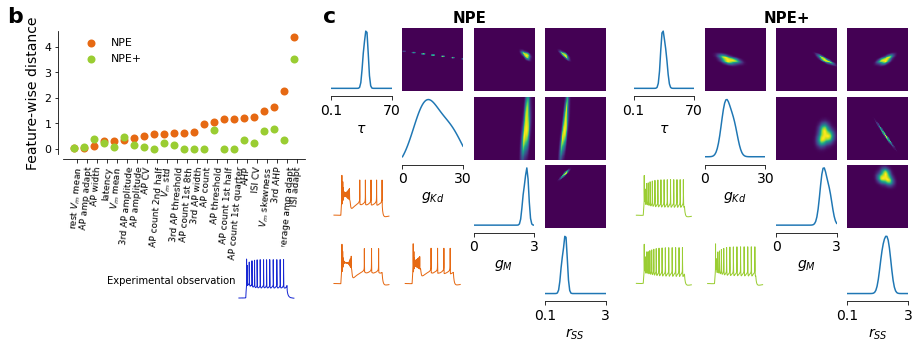

In [230]:
fig=plt.figure(figsize=(12,3.8))


dims_to_show=[2,5,6,12]
lw=1


ax_features, ax_observation, axes_npe, axes_npep = create_figure_1bc(fig)

# Feature-wise performances NPE vs NPE+
order=np.argsort(npe_score)

ax_features.scatter(np.linspace(0,4*len(ephys_features)+1, num=len(ephys_features)),
        npe_score[order],
        color='#e66913ff',
        label='NPE',
        lw=2
       )
ax_features.scatter(np.linspace(0,4*len(ephys_features)+1, num=len(ephys_features)),
        npep_score[order],
        color='yellowgreen',
        label='NPE+',
        lw=2
       )

adjust_spines(ax_features, spines=['bottom', 'left'])


ax_features.set_xticks(np.linspace(1,4*len(ephys_features)+2, num=len(ephys_features)))
ax_features.legend(loc=(.05,.7), fontsize=11, frameon=False)
ax_features.set_ylabel('Feature-wise distance', fontsize=14)
ax_features.set_xticklabels(ephys_features[order], rotation=85)
ax_features.tick_params(axis='y', which='major', labelsize=11)
ax_features.tick_params(axis='x', which='major', labelsize=9)

# Experimental observation
ax_observation.plot(observation['time'], observation['data'], c='#1929d3ff', lw=lw)
ax_observation.set_ylim([ax_observation.get_ylim()[0]-30, ax_observation.get_ylim()[1]+30])
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)

# SBI pairplot
pairplot(
    npe_samples[:,dims_to_show],
    limits=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    ticks=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={'markersize': 6},
    points_colors='r',
    fig=fig,
    axes=axes_npe,
    upper='kde',
    diag='kde'
)

axes_npe[3,0].plot(x_npe['time'],x_npe['data'][0,0,:],lw=lw,color='#e66913ff')
axes_npe[2,0].plot(x_npe['time'],x_npe['data'][1,0,:],lw=lw,color='#e66913ff')
axes_npe[3,1].plot(x_npe['time'],x_npe['data'][2,0,:],lw=lw,color='#e66913ff')

# SBI + noise pairplot
pairplot(
    npep_samples[:,dims_to_show],
    limits=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    ticks=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={'markersize': 6},
    points_colors='r',
    fig=fig,
    axes=axes_npep,
    upper='kde',
    diag='kde'
)
axes_npep[3,0].plot(x_npep['time'],x_npep['data'][0,0,:],lw=lw,color='yellowgreen')
axes_npep[2,0].plot(x_npep['time'],x_npep['data'][1,0,:],lw=lw,color='yellowgreen')
axes_npep[3,1].plot(x_npep['time'],x_npep['data'][2,0,:],lw=lw,color='yellowgreen')

for ax in [axes_npe[3,0],axes_npe[2,0],axes_npe[3,1],axes_npep[3,0],axes_npep[2,0],axes_npep[3,1]]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])

fig.text(-0.065, 1, 'b', fontsize=22, fontweight='bold')
fig.text(.3, 1, 'c', fontsize=22, fontweight='bold')
# fig.text(.65, 1, 'd', fontsize=22, fontweight='bold')

fig.text(.45, 1, 'NPE', fontsize=15, fontweight='bold', color='k')
fig.text(.81, 1, 'NPE+', fontsize=15, fontweight='bold', color='k')

fig.text(.05,.045,'Experimental observation', fontsize=10, color='k')

plt.savefig('../figures/figure_1bc.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_1bc.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 2

t-SNE overlayed with fitted model parameters, fitted electrophysiology, true electrophysiology and marker genes

In [77]:
with open('save_posteriors/training_schedule_0.pickle', 'rb') as f:
    npe_posterior=pickle.load(f)
with open('save_posteriors/training_schedule_2d.pickle', 'rb') as f:
    npep_posterior=pickle.load(f)

Let us get the gene expression levels for the same cells.

In [78]:
data_exons = pd.read_csv('../data/m1_patchseq_exon_counts.csv.gz', na_filter=False, index_col=0)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names

Select 1000 most variable genes.

In [79]:
from rnaseqTools import geneSelection

Chosen offset: 7.53


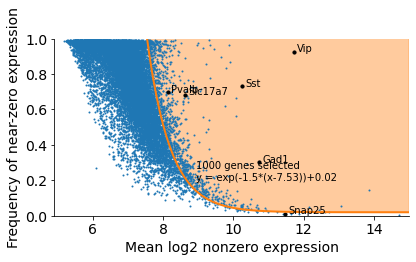

In [80]:
amount_of_genes = 1000
markerGenes = ['Snap25', 'Gad1', 'Slc17a7', 'Pvalb', 'Sst', 'Vip']
selectedGenes = geneSelection(exonCounts, n=amount_of_genes, threshold=30, markers=markerGenes, genes=gene_names)
exonCounts=exonCounts[:,selectedGenes]
gene_names=gene_names[selectedGenes]

Further preprocessing for genes (library size normalization and Z-scoring).

In [81]:
genes = exonCounts.copy()
genes = genes / np.sum(genes, axis=1, keepdims=True) * np.median(np.sum(genes, axis=1, keepdims=True))
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype('float64')

In [82]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [83]:
Z = tsne.fit(G)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.13 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.8282, 50 iterations in 0.2163 sec
Iteration  100, KL divergence 2.7620, 50 iterations in 0.1083 sec
Iteration  150, KL divergence 2.7680, 50 iterations in 0.1036 sec
Iteration  200, KL divergence 2.7121, 50 iterations in 0.0973 sec
Iteration  250, KL divergence 2.7661, 50 iterations in 0.0935 sec
   --> Time elapsed: 0.62 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...

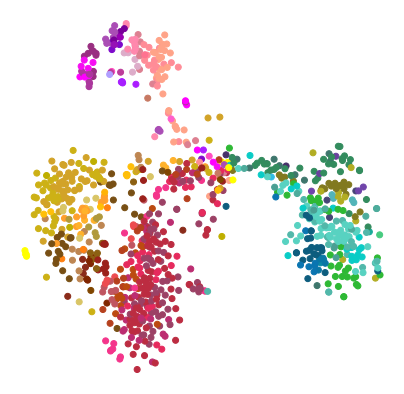

In [84]:
plt.figure(figsize=(7,7))
plt.scatter(Z[:,0],Z[:,1],c=colors)
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)

In [85]:
fav_tr_schedule='2d'

##### Fetch highest posterior samples

In [86]:
with open('save_model_parameters/training_schedule_{}.pickle'.format(fav_tr_schedule), 'rb') as f:
        THETA = pickle.load(f)
highest_posterior_samples=np.concatenate(
    [THETA['highest posterior samples'][cell] if cell in THETA['highest posterior samples'] else np.ones((13,))*np.nan for cell in Xo.index]
).reshape((Xo.shape[0],len(model_param_names)))

##### Fetch random samples with evaluations from the posterior built with our favourite training schedule from `report_performances.ipynb`

In [87]:
with open('save_model_parameters/favourite_training_schedule.pickle', 'rb') as f:
    fav_training_schedule=pickle.load(f)
samples=np.concatenate(
    [fav_training_schedule['samples'][cell] for cell in Xo.index]
).reshape((Xo.shape[0],1000,len(model_param_names)))
samples=torch.as_tensor(samples,dtype=torch.float32)

The following result should be pretty high in comparison to next block's values

In [88]:
npep_posterior.log_prob(highest_posterior_samples[0,:], x=Xo.iloc[0,:].values[feature_list])

tensor([-29.3095])

In [89]:
npep_posterior.log_prob(samples[0,:,:],x=Xo.iloc[0,:].values[feature_list])[:10]

tensor([-37.8570, -33.9139, -32.9070, -37.8549, -34.8669, -34.7582, -33.9929,
        -32.5260, -36.1970, -36.5947])

You can run it once and then simply load next block any other time

In [65]:
uncertainty=np.zeros((Xo.shape[0]))
for i in range(Xo.shape[0]):
    if i%100==0:
        print(i, end='')
    print('.', end='')
    uncertainty[i]=torch.mean(-npep_posterior.log_prob(samples[i,:,:],x=Xo.iloc[i,:].values[feature_list])).item()
np.savez('./save_uncertainty/npep_entropy.npz',
     entropy=uncertainty
        )

0....................................................................................................100....................................................................................................200....................................................................................................300....................................................................................................400....................................................................................................500....................................................................................................600....................................................................................................700....................................................................................................800....................................................................................................900.......................................................

In [90]:
uncertainty=np.load('./save_uncertainty/npep_entropy.npz')['entropy']

In [92]:
MAP_stats=np.load('./save_sims/highest_posterior_samples_summ_stats_{}.npz'.format(fav_tr_schedule))['stats']
MAP_stats=MAP_stats

In [93]:
def create_figure_2(fig):
    
    if fig is None:
        fig = plt.figure(figsize=(14, 10))
    else: fig = fig
    
    width, height=.14, .12
    w_scale, h_scale=width*1.2, height*1.2
    ax_latent=plt.axes([0,.6,(w_scale-.02)*2,h_scale*2])
    axes_marker_genes=np.array(
        [[plt.axes([x,y,width,height]) for x in [.167*2, .167*3]] for y in [.6+h_scale,.6]]
    )
    ax_HH_uncertainty=plt.axes([w_scale*4,.6,w_scale*2,h_scale*2])
    axes_params=np.array([plt.axes([x,.4,width,height]) for x in [0,w_scale,w_scale*2,w_scale*3,w_scale*4,w_scale*5]])
    axes_fitted_ephys=np.array([plt.axes([x,.2,width,height]) for x in [0,w_scale,w_scale*2,w_scale*3,w_scale*4,w_scale*5]])
    axes_true_ephys=np.array([plt.axes([x,0,width,height]) for x in [0,w_scale,w_scale*2,w_scale*3,w_scale*4,w_scale*5]])
    
    return ax_latent, axes_marker_genes, ax_HH_uncertainty, axes_params, axes_fitted_ephys, axes_true_ephys

In [94]:
def latent_space_overlays(Z, X, X_column_index, geneNames, alpha = 1, triangle_max_len=50,
                       fontsize=14, axis = None):
    '''
    Parameters
    ----------
    Z: latent space coordinates (2D numpy array)
    X: normalized overlaying data (2D numpy array)
    X_column_index: column index in X, correspoding to certain feature
    names: list of feature names (X_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))    
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation(Z[:,0], Z[:,1])
    
    # extract coordinates of each triangle
    x1=Z[:,0][triang.triangles][:,0]
    x2=Z[:,0][triang.triangles][:,1]
    x3=Z[:,0][triang.triangles][:,2]
    y1=Z[:,1][triang.triangles][:,0]
    y2=Z[:,1][triang.triangles][:,1]
    y3=Z[:,1][triang.triangles][:,2]
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)>np.max(edges, axis=1)[
            np.argsort(np.max(edges, axis=1))
        ][-triangle_max_len]
    )
    ax.tricontourf(triang, X[:, X_column_index], cmap='inferno',
                   levels=np.linspace(-2,2,5), extend='both')
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    ax.set_title(geneNames[X_column_index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

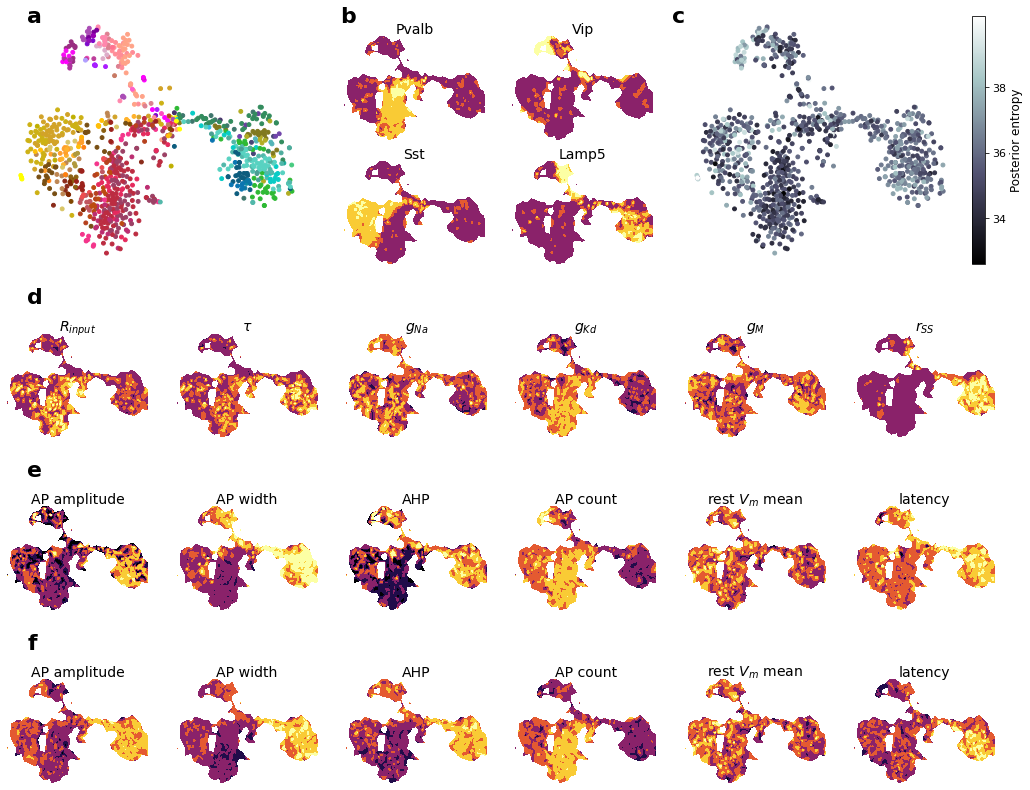

In [95]:
fig = plt.figure(figsize=(14, 12))
ax_latent, axes_marker_genes, ax_HH_uncertainty, axes_params, axes_fitted_ephys, axes_true_ephys = create_figure_2(fig)

# t-SNE latent
ax_latent.scatter(Z[:,0], Z[:,1], s=15, c=colors)
ax_latent.set_xticks([])
ax_latent.set_yticks([])
sns.despine(ax=ax_latent, left=True, bottom=True)

# uncertainty of fitted model parameters
scatter=ax_HH_uncertainty.scatter(Z[:,0], Z[:,1], s=15, c=uncertainty, cmap='bone')
cbar=plt.colorbar(scatter, ax=ax_HH_uncertainty, ticks=[32,34,36,38])#, anchor=(,.5))
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Posterior entropy', fontsize=12)
ax_HH_uncertainty.set_xticks([])
ax_HH_uncertainty.set_yticks([])
sns.despine(ax=ax_HH_uncertainty, left=True, bottom=True)

# marker genes
marker_gene_ids=[
    np.where(gene_names=='Pvalb')[0][0],
    np.where(gene_names=='Vip')[0][0],
    np.where(gene_names=='Sst')[0][0],
    np.where(gene_names=='Lamp5')[0][0]
]
for i, ax in enumerate(axes_marker_genes.reshape(-1)):
    latent_space_overlays(Z, G, 
        marker_gene_ids[i], gene_names, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)

# model params
model_param_ids_to_show=[1,2,4,5,6,-1] 
for i, ax in enumerate(axes_params):
    latent_space_overlays(Z, (highest_posterior_samples-highest_posterior_samples.mean(axis=0))/highest_posterior_samples.std(axis=0), 
        model_param_ids_to_show[i], model_param_names, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)
    
ephys_feature_ids_to_show=[1,2,3,8,19,18]
for i, ax in enumerate(axes_fitted_ephys.reshape(-1)):
    latent_space_overlays(
        Z[~np.isnan(MAP_stats.mean(axis=1)),:],
        (MAP_stats[~np.isnan(MAP_stats.mean(axis=1)),:]-Xo.values.mean(axis=0)[:-4])/Xo.values.std(axis=0)[:-4], 
        ephys_feature_ids_to_show[i], ephys_features, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)
    
for i, ax in enumerate(axes_true_ephys.reshape(-1)):
    latent_space_overlays(Z, (Xo.values[:,:-4]-Xo.values.mean(axis=0)[:-4])/Xo.values.std(axis=0)[:-4], 
        ephys_feature_ids_to_show[i], ephys_features, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)

shift=.02
fig.text(0+shift, .88, 'a', fontsize=22, fontweight='bold')
#fig.text(.11, .91, 'Latent', fontsize=19)
fig.text(.33, .88, 'b', fontsize=22, fontweight='bold')
#fig.text(.43, .91, 'Marker genes', fontsize=19)
fig.text(.66, .88, 'c', fontsize=22, fontweight='bold')
#fig.text(.73, .91, 'Fit uncertainty', fontsize=19)
fig.text(0+shift, .555, 'd', fontsize=22, fontweight='bold')
#fig.text(.03+shift, .555, 'Model parameters', fontsize=19)
fig.text(0+shift, .355, 'e', fontsize=22, fontweight='bold')
#fig.text(.03+shift, .355, 'Model electrophysiology', fontsize=19)
fig.text(0+shift, .155, 'f', fontsize=22, fontweight='bold')
#fig.text(.03+shift, .155, 'Experimental electrophysiology', fontsize=19)

plt.savefig('../figures/figure_2.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_2.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 3

This analysis with figure can be found in **ToDo**.  

### Figure 4 and 5

We use sparse reduced-rank regression to predict model parameters from gene expression levels.

In [96]:
# Allen data t-type ordering:
allen = pickle.load(open('../data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterNames = allen['neurons']['clusterNames']

WARNING    /tmp/ipykernel_16272/668696660.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  allen = pickle.load(open('../data/SmartSeq_cells_AIBS.pickle', 'rb'))
 [py.warnings]
  allen = pickle.load(open('../data/SmartSeq_cells_AIBS.pickle', 'rb'))



In [97]:
clusterNames[np.where(clusterNames=='L5 PT_1')[0]]='L5 ET_1'
clusterNames[np.where(clusterNames=='L5 PT_2')[0]]='L5 ET_2'
clusterNames[np.where(clusterNames=='L5 PT_3')[0]]='L5 ET_3'
clusterNames[np.where(clusterNames=='L5 PT_4')[0]]='L5 ET_4'

In [98]:
ttypes=[]
for ttype in clusterNames:
    if ttype in celltypes.values:
        ttypes.append(ttype)
ttypes=np.array(ttypes)

In [99]:
with open('save_model_parameters/training_schedule_{}.pickle'.format(fav_tr_schedule), 'rb') as f:
        THETA = pickle.load(f)
highest_posterior_samples=np.concatenate(
    [THETA['highest posterior samples'][cell] if cell in THETA['highest posterior samples'] else np.ones((13,))*np.nan for cell in Xo.index]
).reshape((Xo.shape[0],len(model_param_names)))

In [100]:
highest_posterior_samples_standardized=(highest_posterior_samples-highest_posterior_samples.mean(axis=0))/highest_posterior_samples.std(axis=0)
family_av_model_params=np.array([highest_posterior_samples_standardized[family,:].mean(axis=0) for family in [celltype_Lamp5, celltype_Sncg, celltype_Vip, celltype_Sst, celltype_Pvalb, celltype_Pyr]])
df_family=pd.DataFrame(data=family_av_model_params.T, index=model_param_names, columns=['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb', 'Pyr'])
df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,0.869342,0.746463,0.148342,-0.052775,-0.707111,0.462738
$R_{input}$,-0.525422,-0.488019,-0.249764,-0.144427,0.538900,-0.210840
$\tau$,-0.594532,-0.618268,-0.737777,-0.258333,0.194583,0.366017
$g_{Nat}$,-0.343083,-0.155728,-0.007182,0.152399,-0.546905,0.546962
$g_{Na}$,0.364120,0.675551,0.437934,-0.063715,0.073229,-0.241635
$g_{Kd}$,-0.689543,0.486461,-0.361507,-0.047561,0.878260,-0.615111
$g_{M}$,-0.311415,0.355944,-0.379037,-0.018649,0.027352,0.140181
$g_{Kv31}$,-0.552319,-0.832617,-0.494585,0.105840,0.736717,-0.563323
$g_{L}$,-0.252134,0.023523,-0.355963,-0.169835,-0.252113,0.552200
$E_{leak}$,-0.033930,0.261512,-0.139040,0.346914,-0.096545,-0.172346


Briefly, to see average real parameter values across families.

In [101]:
#highest_posterior_samples_standardized=(highest_posterior_samples-THETA_mean)/THETA_std
real_family_av_model_params=np.array([highest_posterior_samples[family,:].mean(axis=0) for family in [celltype_Lamp5, celltype_Sncg, celltype_Vip, celltype_Sst, celltype_Pvalb, celltype_Pyr]])
real_df_family=pd.DataFrame(data=real_family_av_model_params.T, index=model_param_names, columns=['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb', 'Pyr'])
real_df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,12.597243,12.258362,10.608851,10.054210,8.249667,11.475893
$R_{input}$,209.661987,216.940674,263.305511,283.804199,416.780701,270.880249
$\tau$,10.392874,10.034435,8.229717,15.469836,22.309361,24.898191
$g_{Nat}$,81.138390,89.860344,96.775604,104.204582,71.649841,122.572731
$g_{Na}$,58.451485,64.859047,59.970181,49.648941,52.466518,45.988308
$g_{Kd}$,11.390011,20.180321,13.841988,16.188650,23.108923,11.946367
$g_{M}$,1.597893,1.997955,1.557356,1.773397,1.800973,1.868611
$g_{Kv31}$,37.827477,25.550764,40.356152,66.654076,94.285774,37.345509
$g_{L}$,0.850883,1.006905,0.792116,0.897464,0.850895,1.306136
$E_{leak}$,-80.173439,-77.816650,-81.011909,-77.135384,-80.672935,-81.277626


In [102]:
family_av_model_params=np.array([highest_posterior_samples_standardized[celltypes.values==ttype,:].mean(axis=0) for ttype in ttypes])
df_type=pd.DataFrame(data=family_av_model_params.T, index=model_param_names, columns=ttypes)
df_type

,Lamp5 Pax6,Lamp5 Egln3_1,Lamp5 Egln3_2,Lamp5 Pdlim5_1,Lamp5 Pdlim5_2,Lamp5 Slc35d3,Lamp5 Lhx6,Sncg Col14a1,Sncg Calb1_1,Sncg Calb1_2,...,L5 ET_4,L5/6 NP CT,L6 CT Cpa6,L6 CT Grp,L6 CT Pou3f2,L6b Col6a1,L6b Shisa6_1,L6b Shisa6_2,L6b Ror1,L5/6 NP_1
C,0.524181,1.241102,1.107466,1.341990,0.814336,0.804654,0.128617,1.143367,0.750569,0.434514,...,-0.475277,1.314998,0.573675,0.410696,0.347275,0.969252,1.074424,0.850824,0.690123,-0.522196
$R_{input}$,-0.574537,-0.432034,-0.583625,-0.845068,-0.516900,-0.506014,-0.843581,-0.223523,-0.551793,-0.570763,...,-0.492443,0.819462,-0.418106,-0.245292,-0.233947,-0.713612,-0.829666,0.085493,-0.781486,-0.592217
$\tau$,-0.686463,-0.671969,-0.622137,-0.913342,-0.606659,-0.519114,-0.878641,-0.265327,-0.737467,-0.745762,...,-0.227976,0.798028,-0.496839,-0.333908,0.028217,-0.720535,-0.868475,0.622165,-0.965177,-0.822920
$g_{Nat}$,-1.194207,-0.259591,0.070036,-0.258173,-0.285080,-0.402704,-0.277445,-0.075667,-0.530031,-0.504065,...,0.688784,0.638320,0.387353,-0.155938,0.463599,0.429844,1.015027,0.699681,0.240598,0.051695
$g_{Na}$,-0.378207,0.333953,0.492958,1.273617,0.224907,0.431589,1.483254,0.391384,2.125433,0.279149,...,-0.358837,0.685398,-0.025444,-0.418996,-0.104032,0.053599,0.680121,-0.162800,-0.147463,-0.193786
$g_{Kd}$,-0.197503,-0.163263,-1.120509,-1.048841,-0.964527,-0.563595,-1.670792,0.797168,0.247830,1.186309,...,-0.622731,-0.554446,-0.502569,-0.667292,-0.498952,-0.639279,-0.741732,-0.696787,-0.639582,-0.611395
$g_{M}$,0.226110,-0.138358,-0.659507,-0.698051,-0.517856,-0.242124,0.265104,0.413742,0.904843,0.896477,...,0.967444,-0.106645,0.227606,0.574371,0.262975,-0.314560,-1.147178,0.227470,-0.809322,-0.017718
$g_{Kv31}$,-0.179850,-0.673777,-0.759470,-1.084701,-0.716434,-0.389659,-0.779633,-1.094277,-0.649693,-0.212063,...,-0.057281,-1.134489,-0.837652,-0.919460,-0.611627,-1.000311,-1.271770,-0.805786,-1.296257,-1.372768
$g_{L}$,0.057728,-0.294267,-0.706340,-1.293078,-0.609060,0.111878,-0.825602,0.098477,0.850069,0.143995,...,1.615442,-1.150372,-0.484567,-0.128014,-0.140306,-0.345777,-0.715579,-0.465436,-0.596849,-0.975112
$E_{leak}$,0.339366,0.085652,0.647344,0.314793,0.187627,-0.474211,0.343528,-0.145675,0.961288,0.090736,...,0.464038,-0.352070,-0.190101,0.037193,-0.239408,-0.851757,-0.015825,-0.956804,-0.302662,-0.078285


In [103]:
import sparseRRR

In [104]:
data_exons = pd.read_csv('../data/m1_patchseq_exon_counts.csv.gz', na_filter=False, index_col=0)
data_exons = data_exons.T.reindex(Xo.index).T

Some numbers for in the manuscript:

In [105]:
data_exons.shape

(42466, 955)

In [106]:
np.min(np.sum(data_exons.T.values!=0,axis=1))

1202

In [107]:
np.max(np.sum(data_exons.T.values!=0,axis=1))

18118

In [108]:
np.mean(np.sum(data_exons.T.values!=0,axis=1))

7244.528795811519

We load the gene expression levels again but this time keep the ion channel and marker genes. 

In [109]:
data_exons = pd.read_csv('../data/m1_patchseq_exon_counts.csv.gz', na_filter=False, index_col=0)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
IonChannelGenes = pd.read_csv('../data/GO_term_summary_20211104_075621.txt', header = 0, sep = '\t')
selectedGenes = np.array([(gene in IonChannelGenes['MGI Gene/Marker ID'].values) | (gene in ['Pvalb', 'Lamp5', 'Vip', 'Sst', ])  for gene in data_exons.index])
enough_counts = np.sum(data_exons, axis = 1) >= 10
data_exons = data_exons.loc[selectedGenes & enough_counts, :]
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names[selectedGenes & enough_counts]

Further preprocessing for genes (gene selection, library size normalization and Z-scoring)

In [110]:
genes = exonCounts.copy()
genes = genes / np.sum(genes, axis=1, keepdims=True) * np.median(np.sum(genes, axis=1, keepdims=True))
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype('float64')

In [127]:
w,v = sparseRRR.relaxed_elastic_rrr(G, highest_posterior_samples_standardized.astype(np.float64), rank=2, lambdau=0.189, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

Genes selected: 25


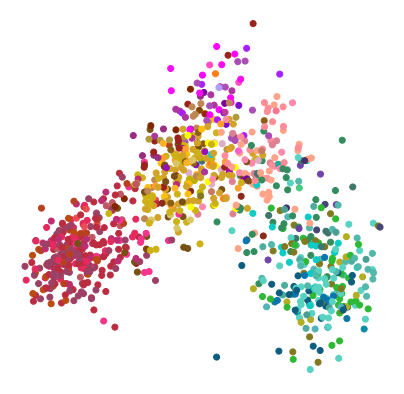

In [128]:
plt.figure(figsize=(7,7))
plt.scatter((G@w)[:,0],(G@w)[:,1], c=colors)
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)

In [130]:
ttype_av_model_params_sRRR=np.array([(G@w@v.T)[celltypes.values==ttype,:].mean(axis=0) for ttype in ttypes])
df_ttype_sRRR=pd.DataFrame(data=ttype_av_model_params_sRRR.T, index=model_param_names, columns=ttypes)
df_ttype_sRRR

,Lamp5 Pax6,Lamp5 Egln3_1,Lamp5 Egln3_2,Lamp5 Pdlim5_1,Lamp5 Pdlim5_2,Lamp5 Slc35d3,Lamp5 Lhx6,Sncg Col14a1,Sncg Calb1_1,Sncg Calb1_2,...,L5 ET_4,L5/6 NP CT,L6 CT Cpa6,L6 CT Grp,L6 CT Pou3f2,L6b Col6a1,L6b Shisa6_1,L6b Shisa6_2,L6b Ror1,L5/6 NP_1
C,0.256659,0.421445,0.389478,0.701820,0.551144,0.469510,0.326909,0.369896,0.092020,0.314123,...,0.361154,0.563453,0.444834,0.332304,0.502251,0.624774,0.599340,0.734082,0.559716,0.608741
$R_{input}$,-0.210684,-0.318903,-0.296000,-0.543808,-0.420241,-0.339543,-0.250062,-0.319541,-0.113031,-0.237532,...,-0.167133,-0.405655,-0.282577,-0.249099,-0.324672,-0.394283,-0.409139,-0.459423,-0.369354,-0.411555
$\tau$,-0.294731,-0.314729,-0.298905,-0.603866,-0.431584,-0.252207,-0.260983,-0.524262,-0.340245,-0.233572,...,0.394385,-0.291249,0.005797,-0.233442,-0.028627,0.024402,-0.169954,0.052709,-0.079043,-0.147583
$g_{Nat}$,0.043946,0.157258,0.141283,0.221772,0.195599,0.224682,0.113509,0.013302,-0.102199,0.117720,...,0.468696,0.275381,0.335945,0.131397,0.361620,0.480014,0.363241,0.576082,0.379290,0.381528
$g_{Na}$,0.127359,0.114792,0.110571,0.235620,0.161266,0.073023,0.098436,0.239013,0.176423,0.084997,...,-0.271820,0.081267,-0.067248,0.082307,-0.056322,-0.103515,0.008488,-0.135025,-0.036488,-0.005336
$g_{Kd}$,-0.243306,-0.433511,-0.399012,-0.705893,-0.562906,-0.502719,-0.332883,-0.330668,-0.040117,-0.323319,...,-0.504879,-0.605601,-0.525457,-0.344774,-0.586215,-0.741276,-0.672262,-0.875795,-0.643819,-0.687834
$g_{M}$,-0.146237,-0.158296,-0.150181,-0.302173,-0.216682,-0.128761,-0.130937,-0.258869,-0.165859,-0.117497,...,0.185469,-0.149001,-0.003645,-0.117698,-0.021123,0.002743,-0.090870,0.014846,-0.046335,-0.080188
$g_{Kv31}$,-0.245166,-0.415663,-0.383513,-0.686023,-0.542036,-0.470682,-0.321121,-0.345637,-0.069756,-0.309892,...,-0.407566,-0.565742,-0.464875,-0.328884,-0.522158,-0.654180,-0.612593,-0.770492,-0.578254,-0.624137
$g_{L}$,-0.164287,-0.110427,-0.109628,-0.258986,-0.163239,-0.030357,-0.101523,-0.330452,-0.279766,-0.081355,...,0.530645,-0.025677,0.201683,-0.073212,0.194598,0.298575,0.104359,0.373445,0.172477,0.129569
$E_{leak}$,0.070986,0.063915,0.061571,0.131248,0.089806,0.040588,0.054821,0.133257,0.098425,0.047325,...,-0.151821,0.045156,-0.037684,0.045818,-0.031606,-0.057986,0.004528,-0.075609,-0.020558,-0.003190


In [131]:
family_av_model_params_sRRR=np.array([(G@w@v.T)[family,:].mean(axis=0) for family in [celltype_Lamp5, celltype_Sncg, celltype_Vip, celltype_Sst, celltype_Pvalb, celltype_Pyr]])
df_family_sRRR=pd.DataFrame(data=family_av_model_params_sRRR.T, index=model_param_names, columns=['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb', 'Pyr'])
df_family_sRRR

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,0.460288,0.316353,0.358483,0.046637,-0.693012,0.460595
$R_{input}$,-0.343798,-0.272067,-0.331088,-0.070645,0.467089,-0.246861
$\tau$,-0.315599,-0.440738,-0.642006,-0.256016,0.159013,0.292087
$g_{Nat}$,0.185901,0.015217,-0.054449,-0.093821,-0.438871,0.491705
$g_{Na}$,0.109687,0.200159,0.306290,0.136002,0.011092,-0.229106
$g_{Kd}$,-0.479117,-0.284337,-0.293568,-0.003546,0.784863,-0.601537
$g_{M}$,-0.159280,-0.217705,-0.315638,-0.124473,0.086937,0.134562
$g_{Kv31}$,-0.456150,-0.296196,-0.324615,-0.028889,0.711236,-0.503475
$g_{L}$,-0.094112,-0.275429,-0.446348,-0.220480,-0.155981,0.478192
$E_{leak}$,0.061053,0.111592,0.170807,0.075883,0.006431,-0.128018


In [133]:
def latent_space_genes_sRRR(X, vx, index, geneNames, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation((X@vx)[:,1], (X@vx)[:,0])
    
    # extract coordinates of eacht triangle
    x1=(X@vx)[:,1][triang.triangles][:,0]
    x2=(X@vx)[:,1][triang.triangles][:,1]
    x3=(X@vx)[:,1][triang.triangles][:,2]
    y1=(X@vx)[:,0][triang.triangles][:,0]
    y2=(X@vx)[:,0][triang.triangles][:,1]
    y3=(X@vx)[:,0][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20])
    ax.tricontourf(triang, X@vx@np.linalg.pinv(vx)[:, np.sum(vx, axis = 1)!=0][:, index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [134]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, alpha = 1, axis = None):

    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation((X@vx)[:,1], (X@vx)[:,0])
    
    # extract coordinates of eacht triangle
    x1=(X@vx)[:,1][triang.triangles][:,0]
    x2=(X@vx)[:,1][triang.triangles][:,1]
    x3=(X@vx)[:,1][triang.triangles][:,2]
    y1=(X@vx)[:,0][triang.triangles][:,0]
    y2=(X@vx)[:,0][triang.triangles][:,1]
    y3=(X@vx)[:,0][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20])
    ax.tricontourf(triang, (X@vx@vy.T)[:, Y_column_index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [193]:
with open('deploy_sRRR_and_sBNN/pickles/sRRR_vs_Bottleneck_rank2_CV_lasso_ion_channel_marker.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)
with open('deploy_sRRR_and_sBNN/pickles/sRRR_vs_Bottleneck_rank13_CV_lasso_ion_channel_marker.pickle', 'rb') as f:
    r2_sRRR_rank13, r2_sRRR_relaxed_rank13, r2_sRRR_rank13_tr, r2_sRRR_relaxed_rank13_tr, \
                nonzero_rank13, corrs_rank13, corrs_relaxed_rank13 = pickle.load(f)
# suppressing "mean of empty slice" warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    cr_13= np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

In [194]:
sRRR_2_multivar_score = 1 - np.sum((highest_posterior_samples_standardized - G @ w @ v.T)**2) / np.sum(highest_posterior_samples_standardized**2)
sRRR_2_ind_score=np.array(
    [1 - np.sum((highest_posterior_samples_standardized[:,i] - (G @ w @ v.T)[:,i])**2) / np.sum(highest_posterior_samples_standardized[:,i]**2) for i in range(len(model_param_names))]
)

In [195]:
sRRR_2_multivar_score

0.19947051223227685

In [196]:
sRRR_2_ind_score

array([0.30010336, 0.13777083, 0.15004232, 0.16044094, 0.04418609,
       0.39485703, 0.03716772, 0.31855027, 0.14366406, 0.01379769,
       0.08727416, 0.18820378, 0.61705812])

In [197]:
n_2

array([77.7, 25.2, 14.9,  6.5,  5.1,  3.6,  3. ,  3. ,  2.8,  2. ,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [198]:
n_13

array([215.4,  45.2,  20.2,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan])

In [199]:
w.shape

(427, 2)

In [200]:
gene_names[w[:,0]!=0]

array(['Cacna2d1', 'Cacna2d2', 'Cacng3', 'Gabra5', 'Gabrd', 'Gpm6a',
       'Grik1', 'Kcnab3', 'Kcnc1', 'Kcnc3', 'Kcnc4', 'Kcnip2', 'Kcnip3',
       'Kcnma1', 'Kcnv1', 'Lamp5', 'Lrrc38', 'Pex5l', 'Pvalb', 'Ryr1',
       'Scn1a', 'Scn3b', 'Slc17a7', 'Slc24a4', 'Vip'], dtype=object)

In [202]:
print(cr_2[np.isclose(n_2, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_2, 25, atol=3)][0])

0.17037856609537325 +/- 0.026022065525568395


In [167]:
def create_figure_4(fig):
    
    if fig is None:
        fig = plt.figure(figsize=(12,6))
    else: fig = fig
    
    width, height = .085,.17
    
    ax_sRRR_schema=plt.axes([0,.65,.33,.35])
    ax_sRRR_cv=plt.axes([.34,.75,.23,.25])
    ax_sRRR_pred=plt.axes([.66,.75,.2,.25])
    
    ax_sRRR_latent=plt.axes([.3,0,.3,.6])
    ax_sRRR_genes=np.array([[plt.axes([x,y,width,height]) for x in [0,.1,.2]] for y in [.4,.2,0]])
    ax_sRRR_model_params=np.array([[plt.axes([.59+x,y,width,height]) for x in [0,.1,.2]] for y in [.4,.2,0]])
    
    return ax_sRRR_schema, ax_sRRR_cv, ax_sRRR_pred, ax_sRRR_latent, ax_sRRR_genes, ax_sRRR_model_params

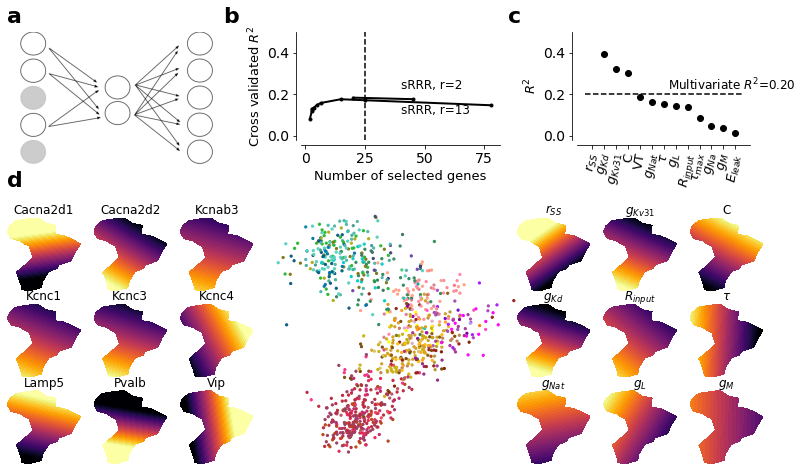

In [176]:
fig=plt.figure(figsize=(12,6))

ax_sRRR_schema, ax_sRRR_cv, ax_sRRR_pred, ax_sRRR_latent, ax_sRRR_genes, ax_sRRR_model_params = create_figure_4(fig)

import matplotlib.image as mpimg
img = mpimg.imread('../figures/sRRR_sketch.png')

ax_sRRR_schema.imshow(img)
ax_sRRR_schema.set_xticks([])
ax_sRRR_schema.set_yticks([])
sns.despine(ax=ax_sRRR_schema, left=True, bottom=True)

dims_to_show=[2,5,6,12]

ax_sRRR_cv.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax_sRRR_cv.plot(n_13[1:], cr_13[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax_sRRR_cv.set_ylim([-0.02,0.5])
ax_sRRR_cv.set_xlabel('Number of selected genes', fontsize = 13)
ax_sRRR_cv.set_ylabel(r'Cross validated $R^2$', fontsize = 13)
ax_sRRR_cv.vlines(x=25, ymin=ax_sRRR_cv.get_ylim()[0], ymax=ax_sRRR_cv.get_ylim()[1], linestyles='dashed', color='black')
ax_sRRR_cv.annotate('sRRR, r=13', (40, np.max(cr_13)-0.08), fontsize=12)
ax_sRRR_cv.annotate('sRRR, r=2', (40, np.max(cr_2)+0.05), fontsize=12)

adjust_spines(ax_sRRR_cv,['bottom', 'left'])

order=np.argsort(sRRR_2_ind_score)[::-1]
ax_sRRR_pred.scatter(range(len(model_param_names)), sRRR_2_ind_score[order], color='black')
ax_sRRR_pred.hlines(sRRR_2_multivar_score,
          xmin=ax_sRRR_pred.get_xlim()[0],
          xmax=ax_sRRR_pred.get_xlim()[1],
          linestyle='dashed',
          color='black')
ax_sRRR_pred.annotate(r'Multivariate $R^2$={0:.2f}'.format(sRRR_2_multivar_score),
           (ax_sRRR_pred.get_xlim()[0]+1.05*(ax_sRRR_pred.get_xlim()[1]-ax_sRRR_pred.get_xlim()[0])/2,
            sRRR_2_multivar_score+0.02),
            fontsize=12)
ax_sRRR_pred.set_ylim([-0.02,0.5])
ax_sRRR_pred.set_ylabel(r'$R^2$', fontsize=13)
ax_sRRR_pred.set_xticks(range(len(model_param_names)))
adjust_spines(ax_sRRR_pred,['bottom', 'left'])
ax_sRRR_pred.set_xticklabels(model_param_names[order], rotation='80', fontsize=13)


ax_sRRR_latent.scatter((G@w)[:,1],(G@w)[:,0], s=5, c=colors)
ax_sRRR_latent.set_xticks([])
ax_sRRR_latent.set_yticks([])
sns.despine(ax=ax_sRRR_latent, left=True, bottom=True)

gene_indices_for_visualization=[0,1,7,8,9,10,15,18,24]

for i, ax in enumerate(ax_sRRR_genes.reshape(-1)):
    latent_space_genes_sRRR(G, w, 
        gene_indices_for_visualization[i], gene_names, axis=ax)
    sns.despine(ax=ax, left=True, bottom=True)

model_param_names_indices_for_visualization=[-1,7,0,5,1,2,3,8,6]

for i, ax in enumerate(ax_sRRR_model_params.reshape(-1)):
    latent_space_ephys_sRRR(G, w, v, \
        model_param_names_indices_for_visualization[i], model_param_names, axis=ax)
    sns.despine(ax=ax, left=True, bottom=True)
    
fig.text(0, 1.02, 'a', fontsize=22, fontweight='bold')
fig.text(.25, 1.02, 'b', fontsize=22, fontweight='bold')
fig.text(.58, 1.02, 'c', fontsize=22, fontweight='bold')
fig.text(0, .64, 'd', fontsize=22, fontweight='bold')
    
plt.savefig('../figures/figure_4.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_4.pdf', bbox_inches = 'tight', pad_inches = 0)

In [190]:
def create_figure_5(fig):
    
    if fig is None:
        fig = plt.figure(figsize=(12,5))
    else: fig = fig
    
    ax_df_npep_fam=plt.axes([0.05,0.5,.08,.45])
    ax_df_npep_ttype=plt.axes([.15,0.5,.85,.45])
    ax_df_sRRR_fam=plt.axes([0.05,0,.08,.45])
    ax_df_sRRR_ttype=plt.axes([.15,0,.85,.45])
    
    return ax_df_npep_fam, ax_df_npep_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype

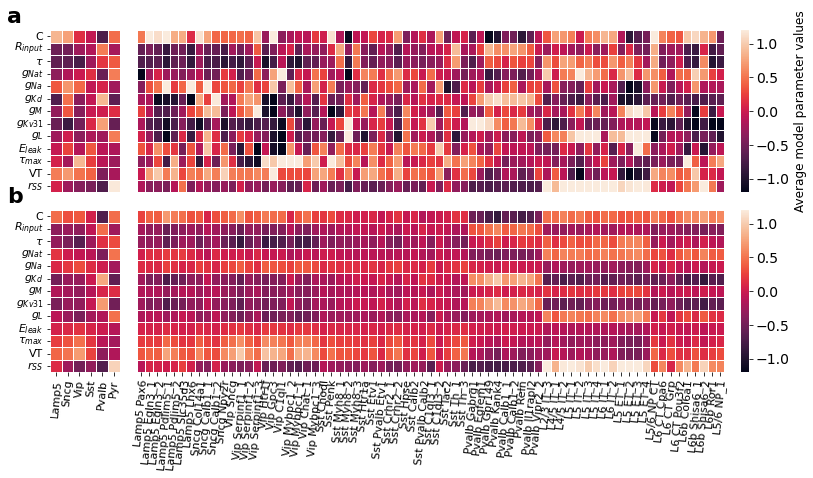

In [192]:
fig=plt.figure(figsize=(12,5))

ax_df_npep_fam, ax_df_npep_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype = create_figure_5(fig)

sns.heatmap(df_family, xticklabels=True, yticklabels=model_param_names, linewidth=.5, vmin=-1.2, vmax=1.2, cbar=False, ax=ax_df_npep_fam)
sns.heatmap(df_type, xticklabels=True, linewidth=.5, yticklabels=[], vmin=-1.2, vmax=1.2, ax=ax_df_npep_ttype, cbar_kws={'label': 'Average model parameter from genes', 'anchor':(-0.2,0.5)})
ax_df_npep_ttype.set_xticks([]);
ax_df_npep_fam.set_xticks([]);
ax_df_npep_fam.set_yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
ax_df_npep_fam.set_yticklabels(model_param_names, fontsize=11);
ax_df_npep_ttype.collections[0].colorbar.set_label('Average model parameter values', fontsize=12)
    
sns.heatmap(df_family_sRRR, xticklabels=True, linewidth=.5, yticklabels=model_param_names, vmin=-1.2, vmax=1.2, cbar=False, ax=ax_df_sRRR_fam)
sns.heatmap(df_ttype_sRRR, xticklabels=True, linewidth=.5, yticklabels=[], vmin=-1.2, vmax=1.2, ax=ax_df_sRRR_ttype, cbar_kws={'anchor':(-0.2,0.5)})
ax_df_sRRR_fam.set_xticklabels(ax_df_sRRR_fam.get_xticklabels(), fontsize=11, rotation=85);
ax_df_sRRR_ttype.set_xticklabels(ax_df_sRRR_ttype.get_xticklabels(), fontsize=11, rotation=85);
ax_df_sRRR_fam.set_yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
ax_df_sRRR_fam.set_yticklabels(model_param_names, fontsize=11);

fig.text(0, .97, 'a', fontsize=22, fontweight='bold')
fig.text(0, .47, 'b', fontsize=22, fontweight='bold')

plt.savefig('../figures/figure_5.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_5.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 6

Average family simulations on the tSNE

In [150]:
# Get average family simulations, from fitting with sbip
x_Pvalb=M1_model._run_HH_model(highest_posterior_samples[celltype_Pvalb.values,:].mean(axis=0))
x_Vip=M1_model._run_HH_model(highest_posterior_samples[celltype_Vip.values,:].mean(axis=0))
x_Sst=M1_model._run_HH_model(highest_posterior_samples[celltype_Sst.values,:].mean(axis=0))
x_Lamp5=M1_model._run_HH_model(highest_posterior_samples[celltype_Lamp5.values,:].mean(axis=0))
x_Pyr=M1_model._run_HH_model(highest_posterior_samples[celltype_Pyr.values,:].mean(axis=0))
x_Sncg=M1_model._run_HH_model(highest_posterior_samples[celltype_Sncg.values,:].mean(axis=0))

In [153]:
# Get average family simulations, from utilizing genes and predicting fitted model parameter distributions with sRRR (for entire dataset, based on good cv results)
x_g_Pvalb_sRRR=M1_model._run_HH_model(((G@w@v.T)[celltype_Pvalb.values,:].mean(axis=0))*highest_posterior_samples.std(axis=0)+highest_posterior_samples.mean(axis=0))
x_g_Vip_sRRR=M1_model._run_HH_model(((G@w@v.T)[celltype_Vip.values,:].mean(axis=0))*highest_posterior_samples.std(axis=0)+highest_posterior_samples.mean(axis=0))
x_g_Sst_sRRR=M1_model._run_HH_model(((G@w@v.T)[celltype_Sst.values,:].mean(axis=0))*highest_posterior_samples.std(axis=0)+highest_posterior_samples.mean(axis=0))
x_g_Lamp5_sRRR=M1_model._run_HH_model(((G@w@v.T)[celltype_Lamp5.values,:].mean(axis=0))*highest_posterior_samples.std(axis=0)+highest_posterior_samples.mean(axis=0))
x_g_Pyr_sRRR=M1_model._run_HH_model(((G@w@v.T)[celltype_Pyr.values,:].mean(axis=0))*highest_posterior_samples.std(axis=0)+highest_posterior_samples.mean(axis=0))
x_g_Sncg_sRRR=M1_model._run_HH_model(((G@w@v.T)[celltype_Sncg.values,:].mean(axis=0))*highest_posterior_samples.std(axis=0)+highest_posterior_samples.mean(axis=0))

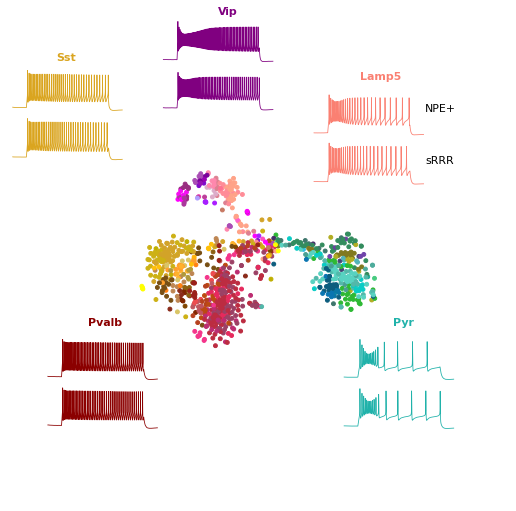

In [234]:
width, height= .24, .09
lw=.8

# ax=axes[0]
# ax_g=axes[1]

fig, ax=plt.subplots(1,1,figsize=(9,9))

ax.scatter(Z[:,0], Z[:,1], s=15, c=colors, zorder=1)
ax.set_xlim([ax.get_xlim()[0]-30, ax.get_xlim()[1]+30])
ax.set_ylim([ax.get_ylim()[0]-30, ax.get_ylim()[1]+30])

ax_Pvalb=ax.inset_axes([0.07, .25,width,height], zorder=0)
ax_Pvalb.plot(x_Pvalb['time'], x_Pvalb['data'][0,0,:], lw=lw, c='darkred')
ax_g_Pvalb=ax.inset_axes([0.07,.15,width,height], zorder=0)
ax_g_Pvalb.plot(x_g_Pvalb_sRRR['time'], x_g_Pvalb_sRRR['data'][0,0,:], lw=lw, c='darkred')
ax_g_Pvalb.set_xlim([ax_Pvalb.get_xlim()[0],ax_Pvalb.get_xlim()[1]])
ax_g_Pvalb.set_ylim([ax_Pvalb.get_ylim()[0],ax_Pvalb.get_ylim()[1]])
    
ax_Vip=ax.inset_axes([.3,.9,width,height], zorder=0)
ax_Vip.plot(x_Vip['time'], x_Vip['data'][0,0,:], lw=lw, c='purple')
ax_g_Vip=ax.inset_axes([.3,.8,width,height], zorder=0)
ax_g_Vip.plot(x_g_Vip_sRRR['time'], x_g_Vip_sRRR['data'][0,0,:], lw=lw, c='purple')
ax_g_Vip.set_xlim([ax_Vip.get_xlim()[0],ax_Vip.get_xlim()[1]])
ax_g_Vip.set_ylim([ax_Vip.get_ylim()[0],ax_Vip.get_ylim()[1]])


ax_Sst=ax.inset_axes([0,.8,width,height], zorder=0)
ax_Sst.plot(x_Sst['time'], x_Sst['data'][0,0,:], lw=lw, c='goldenrod')
ax_g_Sst=ax.inset_axes([0,.7,width,height], zorder=0)
ax_g_Sst.plot(x_g_Sst_sRRR['time'], x_g_Sst_sRRR['data'][0,0,:], lw=lw, c='goldenrod')
ax_g_Sst.set_xlim([ax_Sst.get_xlim()[0],ax_Sst.get_xlim()[1]])
ax_g_Sst.set_ylim([ax_Sst.get_ylim()[0],ax_Sst.get_ylim()[1]])

ax_Lamp5=ax.inset_axes([.6,.75,width,height], zorder=0)
ax_Lamp5.plot(x_Lamp5['time'], x_Lamp5['data'][0,0,:], lw=lw, c='salmon')
ax_g_Lamp5=ax.inset_axes([.6,.65,width,height], zorder=0)
ax_g_Lamp5.plot(x_g_Lamp5_sRRR['time'], x_g_Lamp5_sRRR['data'][0,0,:], lw=lw, c='salmon')
ax_g_Lamp5.set_xlim([ax_Lamp5.get_xlim()[0],ax_Lamp5.get_xlim()[1]])
ax_g_Lamp5.set_ylim([ax_Lamp5.get_ylim()[0],ax_Lamp5.get_ylim()[1]])

ax_Pyr=ax.inset_axes([.66,.25,width,height], zorder=0)
ax_Pyr.plot(x_Pyr['time'], x_Pyr['data'][0,0,:], lw=lw, c='lightseagreen')
ax_g_Pyr=ax.inset_axes([.66,.15,width,height], zorder=0)
ax_g_Pyr.plot(x_g_Pyr_sRRR['time'], x_g_Pyr_sRRR['data'][0,0,:], lw=lw, c='lightseagreen')
ax_g_Pyr.set_xlim([ax_Pyr.get_xlim()[0],ax_Pyr.get_xlim()[1]])
ax_g_Pyr.set_ylim([ax_Pyr.get_ylim()[0],ax_Pyr.get_ylim()[1]])

for ax_ in [ax, ax_Pvalb, ax_g_Pvalb, ax_Vip, ax_g_Vip, ax_Sst, ax_g_Sst,
            ax_Lamp5, ax_g_Lamp5,
            ax_Pyr, ax_g_Pyr]:
    ax_.set_xticks([])
    ax_.set_yticks([])
    sns.despine(ax=ax_, left=True, bottom=True)

fig.text(0.77,.73,'NPE+', fontsize=11, color='black')
fig.text(0.77,.65,'sRRR', fontsize=11, color='black')

fig.text(0.25, .4, 'Pvalb', fontsize=11, color='darkred', fontweight='bold')
fig.text(.45, .88, 'Vip', fontsize=11, color='purple', fontweight='bold')
fig.text(.2, .81, 'Sst', fontsize=11, color='goldenrod', fontweight='bold')
fig.text(.67, .78, 'Lamp5', fontsize=11, color='salmon', fontweight='bold')
fig.text(.72, .4, 'Pyr', fontsize=11, color='lightseagreen', fontweight='bold')
    
plt.savefig('../figures/figure_6.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_6.pdf', bbox_inches = 'tight', pad_inches = 0)